In [1]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision.io import read_image
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, autoaugment
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b4
from torchvision.transforms import autoaugment
import os
import time
import copy
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_list = [file for file in os.listdir(img_dir) if file.endswith('.png')]
        self.transform = transform
        self.img_list.sort()

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = self.img_list[idx]
        img_path = f'{self.img_dir}{img_name}'
        image = np.array(Image.open(img_path))
        label = torch.tensor(int(img_name.split('_')[0]))
        if self.transform:
            image = self.transform(image)
        return image, label, img_name

In [3]:
train_img_dir = "./hw1_data/p1_data/train_50/"
test_img_dir = "./hw1_data/p1_data/val_50/"

In [4]:
train_data = ImageDataset(img_dir=train_img_dir, transform=None)
test_data = ImageDataset(img_dir=test_img_dir, transform=None)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

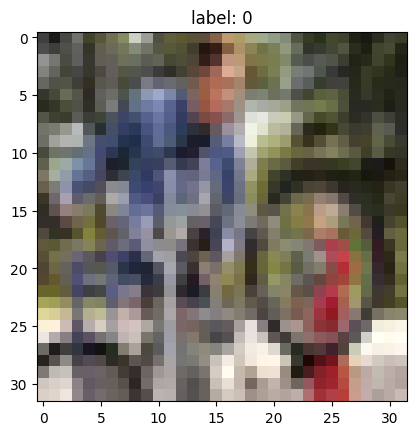

In [5]:
img, label, img_name = test_data[0]
plt.title(f'label: {label.argmax(0).item()}')
plt.imshow(img)
plt.show()

Feature batch shape: torch.Size([64, 32, 32, 3])
Labels batch shape: torch.Size([64])
Names batch shape: 64


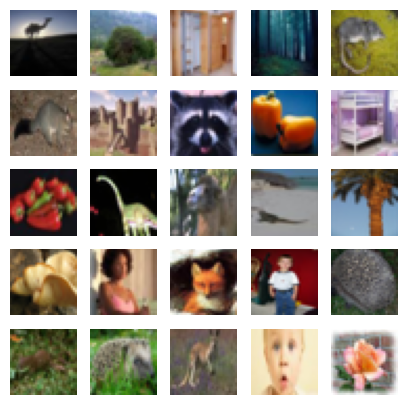

In [6]:
train_features, train_labels, train_names = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(f"Names batch shape: {len(train_names)}")

figure = plt.figure(figsize=(5, 5))
cols, rows = 5, 5
for i in range(1, cols*rows+1):
    img, label = train_features[i], train_labels[i]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [5]:
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.ConvertImageDtype(torch.uint8),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.AutoAugment(policy=autoaugment.AutoAugmentPolicy('imagenet')),
                                      transforms.RandomResizedCrop((128, 128)),
                                      transforms.ConvertImageDtype(torch.float),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.ConvertImageDtype(torch.uint8),
                                     transforms.Resize((128, 128)),
                                     transforms.ConvertImageDtype(torch.float),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
batch_size = 512

In [6]:
train_data = ImageDataset(img_dir=train_img_dir, transform=train_transform)
test_data = ImageDataset(img_dir=test_img_dir, transform=test_transform)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [7]:
efficientnet_b4()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [8]:
class efficientnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = efficientnet_b4(weights=None)
        self.classifier2 =  nn.Sequential(nn.ReLU(),
                                          nn.Dropout(p=0.5),
                                          nn.Linear(1000, 50))

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier2(x)
        return x
    
model = efficientnet()
model

efficientnet(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (s

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# model = torch.load('cnn_efficientB4/model_50.pth')
model.to(device)

best_model = efficientnet()
best_acc = 0.0
# best_acc = 0.7112
# best_model = torch.load('cnn_efficientB4/best_model.pth')

record = {'train_loss':[], 'train_acc':[],'test_loss':[], 'test_acc':[]}
# record_load = np.load('cnn_efficientB4/record.npz')
# record['train_loss'] = record_load['train_loss'].tolist()
# record['train_acc'] = record_load['train_acc'].tolist()
# record['test_loss'] = record_load['test_loss'].tolist()
# record['test_acc'] = record_load['test_acc'].tolist()

cuda:0


In [10]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    step = int(num_batches/10)
    train_loss, train_acc = 0, 0
    for batch, (X, y, n) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        batch_acc = (pred.argmax(1)==y).sum().item()
        train_acc += batch_acc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % step == 0:
            loss, current = loss.item(), (batch+1)*len(X)
            print(f"loss: {loss:>7f}, acc: {(100*batch_acc/batch_size):>0.1f}%  [{current:>5d}/{size:>5d}]")
    if scheduler is not None:
        scheduler.step()
    train_loss /= num_batches
    train_acc /= size
    print(f"Train | Avg_loss: {train_loss:>8f}, Accuracy: {(100*train_acc):>0.1f}%")
    return train_loss, train_acc

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for X, y, n in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_acc += (pred.argmax(1)==y).sum().item()
    test_loss /= num_batches
    test_acc /= size
    print(f"Test  | Avg_loss: {test_loss:>8f}, Accuracy: {(100*test_acc):>0.1f}%\n")
    return test_loss, test_acc

In [11]:
learning_rate = 1e-4
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

In [ ]:
epochs = 100
for e in range(1, epochs+1):
    ee = len(record['train_loss'])+1
    print(f"Epoch {ee}\n-------------------------------")
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer, scheduler)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn)
    record['train_loss'].append(train_loss)
    record['train_acc'].append(train_acc)
    record['test_loss'].append(test_loss)
    record['test_acc'].append(test_acc)
    if test_acc > best_acc:
        best_acc = test_acc
        best_model.load_state_dict(model.state_dict())
    ee = len(record['train_loss'])-1
    if (ee%25 == 0) or (ee == 1):
        torch.save(model, f'model_{ee}.pth')
        torch.save(best_model, f'best_model.pth')
        np.savez(f'record', train_loss=np.array(record['train_loss']), train_acc=np.array(record['train_acc']),
                 test_loss=np.array(record['test_loss']), test_acc=np.array(record['test_acc']))
print("Done!")

Epoch 308
-------------------------------
loss: 1.243585, acc: 67.2%  [   64/22500]


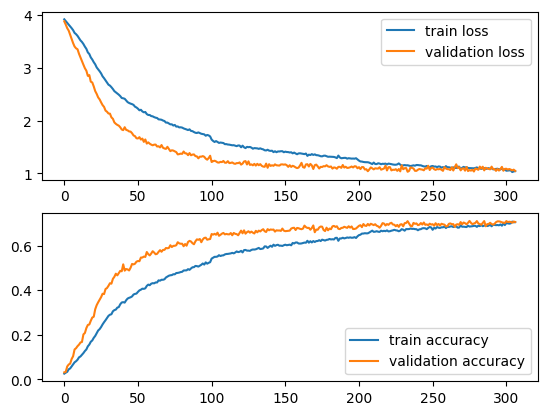

In [14]:
plt.figure()
plt.subplot(211)
plt.plot(np.arange(len(record['train_loss'])), record['train_loss'], np.arange(len(record['test_loss'])), record['test_loss'])
plt.legend(['train loss', 'validation loss'])
plt.subplot(212)
plt.plot(np.arange(len(record['train_acc'])), record['train_acc'], np.arange(len(record['test_acc'])), record['test_acc'])
plt.legend(['train accuracy', 'validation accuracy'])
plt.show()

In [15]:
max(record['test_acc'])

0.7112

In [16]:
torch.save(model, 'model.pth')
torch.save(best_model, 'best_model.pth')
np.savez(f'record', train_loss=np.array(record['train_loss']), train_acc=np.array(record['train_acc']),
           test_loss=np.array(record['test_loss']), test_acc=np.array(record['test_acc']))

In [12]:
test_loop(test_dataloader, model.to(device), loss_fn)

Test  | Avg_loss: 1.574456, Accuracy: 55.7%



(1.5744555473327637, 0.5568)

In [13]:
def get_feature(model, dataloader):
    model.to(device)
    result = list()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    with torch.no_grad():
        for img, label, name in dataloader:
            img = img.to(device)
            feature = model.base_model(img)
            feature  = feature.to('cpu')
            for i in range(len(name)):
                result.append([feature[i].numpy().tolist(), label[i].item()])
    result.sort(key=lambda s: s[1])
    return result

In [14]:
features = get_feature(model, test_dataloader)
len(features)

2500

In [16]:
import pickle
with open('features_middle.pickle', 'wb') as file:
    pickle.dump(features, file)

In [60]:
import pickle
with open('features_first.pickle', 'rb') as file:
    features = pickle.load(file)

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [62]:
feature = []
for f in features:
    feature.append(f[0])
feature = np.array(feature)
feature.shape

(2500, 1000)

In [63]:
pca_feaure = PCA(n_components=3, copy=False).fit_transform(feature)
pca_feaure.shape

(2500, 3)

In [64]:
a = [0.0, 0.33, 0.66, 1.0]
color_list = np.zeros((64,3))
for i in range(color_list.shape[0]):
    color_list[i][0] = a[i%4]
    color_list[i][1] = a[i//4%4]
    color_list[i][2] = a[i//16%4]
color_list

array([[0.  , 0.  , 0.  ],
       [0.33, 0.  , 0.  ],
       [0.66, 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 0.33, 0.  ],
       [0.33, 0.33, 0.  ],
       [0.66, 0.33, 0.  ],
       [1.  , 0.33, 0.  ],
       [0.  , 0.66, 0.  ],
       [0.33, 0.66, 0.  ],
       [0.66, 0.66, 0.  ],
       [1.  , 0.66, 0.  ],
       [0.  , 1.  , 0.  ],
       [0.33, 1.  , 0.  ],
       [0.66, 1.  , 0.  ],
       [1.  , 1.  , 0.  ],
       [0.  , 0.  , 0.33],
       [0.33, 0.  , 0.33],
       [0.66, 0.  , 0.33],
       [1.  , 0.  , 0.33],
       [0.  , 0.33, 0.33],
       [0.33, 0.33, 0.33],
       [0.66, 0.33, 0.33],
       [1.  , 0.33, 0.33],
       [0.  , 0.66, 0.33],
       [0.33, 0.66, 0.33],
       [0.66, 0.66, 0.33],
       [1.  , 0.66, 0.33],
       [0.  , 1.  , 0.33],
       [0.33, 1.  , 0.33],
       [0.66, 1.  , 0.33],
       [1.  , 1.  , 0.33],
       [0.  , 0.  , 0.66],
       [0.33, 0.  , 0.66],
       [0.66, 0.  , 0.66],
       [1.  , 0.  , 0.66],
       [0.  , 0.33, 0.66],
 

In [65]:
color_map = []
for i in range(2500):
    color_map.append(color_list[i//50])
color_map = np.array(color_map)
color_map

array([[0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  ],
       ...,
       [0.33, 0.  , 1.  ],
       [0.33, 0.  , 1.  ],
       [0.33, 0.  , 1.  ]])

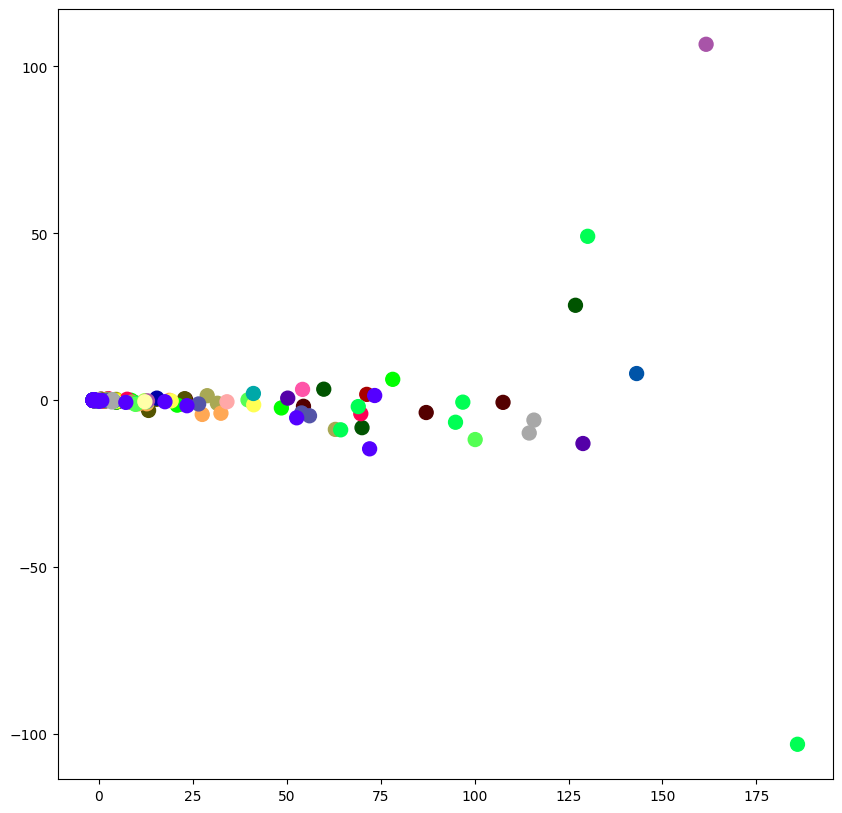

In [66]:
plt.figure(figsize=(10,10))
plt.scatter(pca_feaure[:,0], pca_feaure[:,1], s=100, c=color_map)
plt.show()

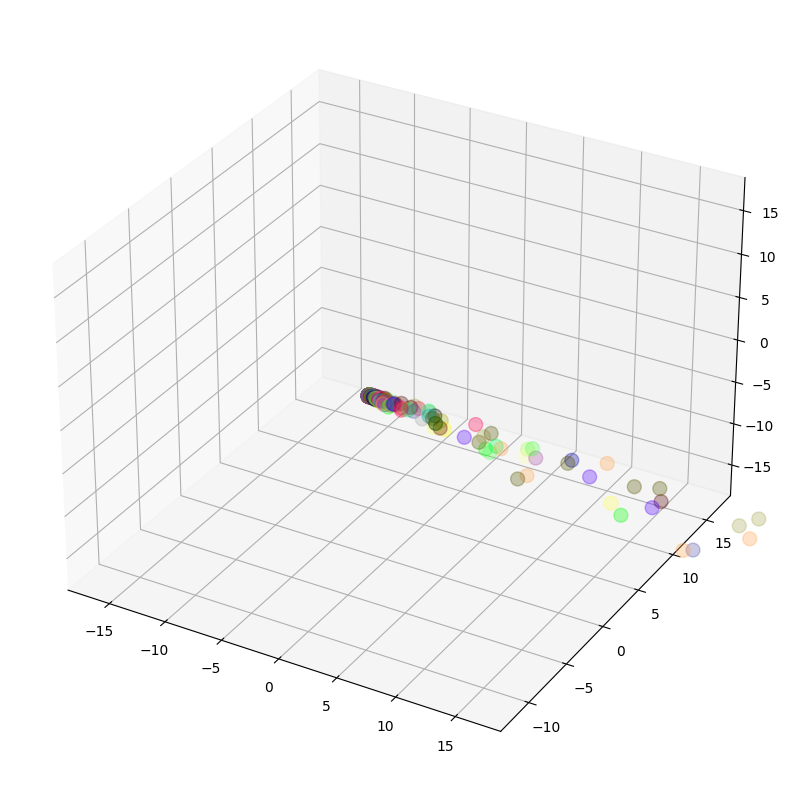

In [67]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(pca_feaure[:,0], pca_feaure[:,1], pca_feaure[:,2], s=100, c=color_map)
ax.set_xbound(-18,18)
ax.set_ybound(-13,18)
ax.set_zbound(-18,18)
plt.show()

In [74]:
tsne2_feaure = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(feature)
tsne2_feaure.shape

(2500, 2)

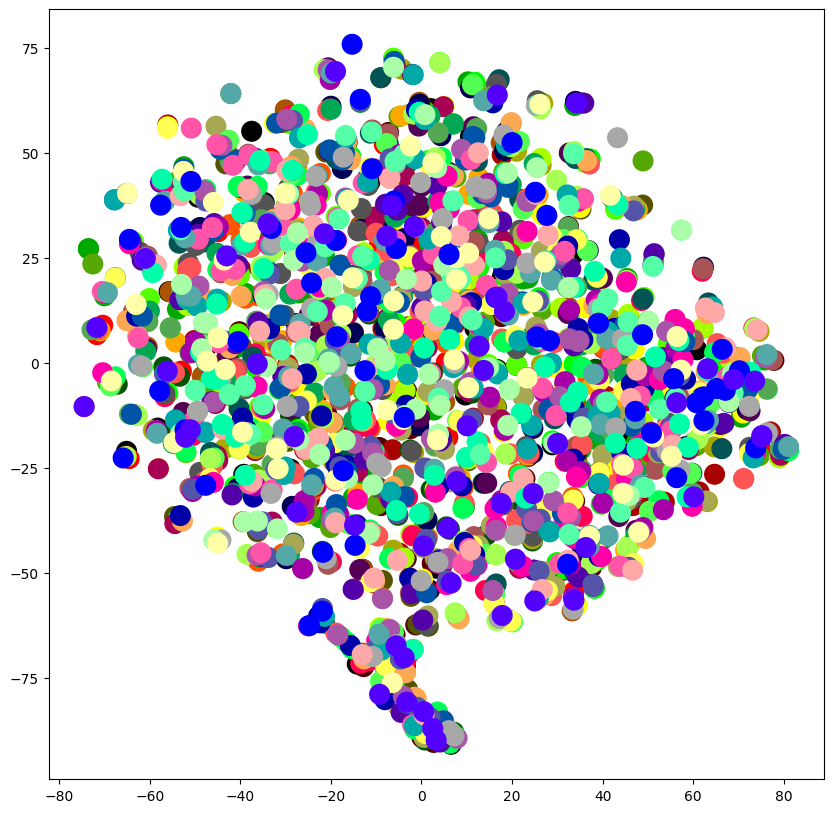

In [75]:
plt.figure(figsize=(10,10))
plt.scatter(tsne2_feaure[:,0], tsne2_feaure[:,1], s=200, c=color_map)
plt.show()

In [39]:
tsne3_feaure = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(feature)
tsne3_feaure.shape

(2500, 3)

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(tsne3_feaure[:,0], tsne3_feaure[:,1], s=100, c=color_map)
plt.show()

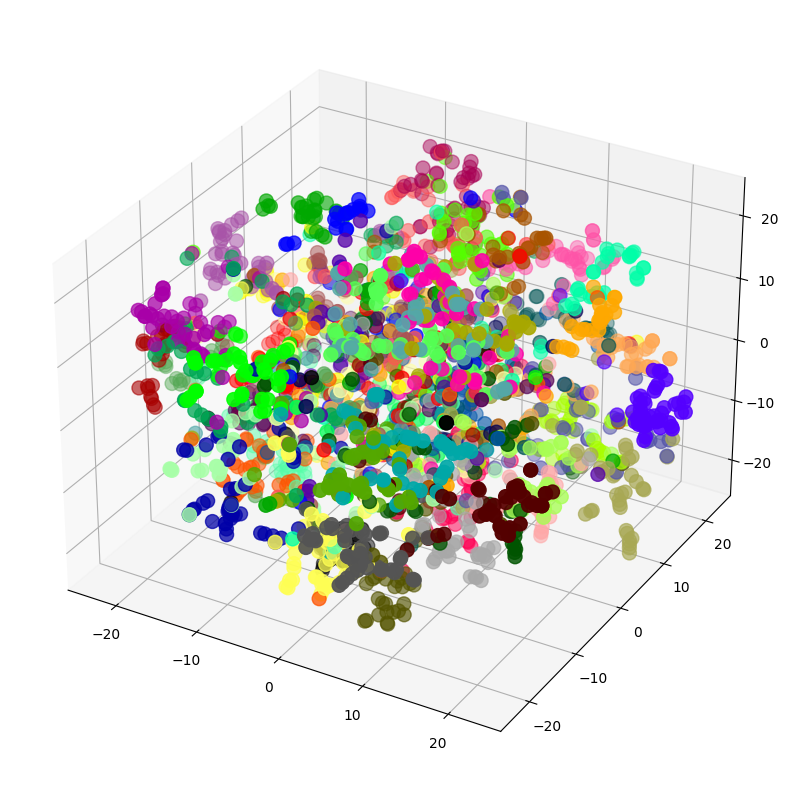

In [29]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(tsne3_feaure[:,0], tsne3_feaure[:,1], tsne3_feaure[:,2], s=100, c=color_map)
ax.set_xbound(-25,25)
ax.set_ybound(-25,25)
ax.set_zbound(-25,25)
plt.show()